In [1]:
import os
os.chdir(r'D:\Computer Vision Camp\Computer Vision Homework nr. 5\utils')

In [2]:
!pip install pycocotools

In [3]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

from PIL.ExifTags import TAGS
from engine import train_one_epoch, evaluate
import utils
from torchvision import transforms as T

In [4]:
class DataSet(torch.utils.data.Dataset):
    
    def __init__(self,root, data_file, transform):
        self.root = root ### mapa cu fotografii
        self.transform = transform
        self.data = pd.read_csv(data_file, sep=';')
        self.imgs = self.data['image_path'].values
        self.path_to_data_file = data_file
        
    def __getitem__(self,idx):
        
        img_path = os.path.join(self.root,self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        
        
        for orientation in TAGS.keys() : 
            if TAGS[orientation]=='Orientation' : break 
        # Getting the exif
        exif=dict(img.getexif().items())
        # Rotating the image if the orientation is wrong.
        if len(exif)!=0:                                                             
            if orientation in exif.keys():
                if exif[orientation] == 3 : 
                    img=img.rotate(180, expand=True)
                elif exif[orientation] == 6 : 
                    img=img.rotate(270, expand=True)
                elif exif[orientation] == 8 : 
                    img=img.rotate(90, expand=True)
                    
        box_list = self.data[self.data['image_path']==self.imgs[idx]][['x_min','y_min','x_max','y_max']].values
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_obj = len(box_list)
        labels = torch.ones((num_obj,), dtype = torch.int64)
        iscrowd = torch.zeros((num_obj,), dtype=torch.int64)
        area = (boxes[:,3] - boxes[:, 1]) * (boxes[:,2] - boxes[:, 0])
        
        image_id = torch.tensor([idx])
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        target['image_id'] = image_id
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, target
    
    def __len__(self):
        return len(self.data)

In [5]:
transformations = T.Compose([T.ToTensor()])

dataset = DataSet(r'D:\Computer Vision Camp\Computer Vision Homework nr. 5\data',
                  r'D:\Computer Vision Camp\Computer Vision Homework nr. 5\handguns.csv',
                  transformations)

torch.manual_seed(1)

indices = torch.randperm(len(dataset)).tolist()
train = torch.utils.data.Subset(dataset, indices[:100])
test = torch.utils.data.Subset(dataset, indices[100:])

train_loader = torch.utils.data.DataLoader(train, batch_size = 1, shuffle=True, collate_fn = utils.collate_fn)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle=False, collate_fn = utils.collate_fn)

In [6]:
def get_model(num_clase):
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    for param in model.parameters():
        param.required_grad = False
        
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_clase)
    
    return model

In [7]:
DEVICE = torch.device('cpu')

num_clase = 2
model = get_model(num_clase).to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr = 0.005, momentum=0.9, weight_decay = 0.0005)

In [8]:
num_epoch = 5

for epoch in range(num_epoch):
    
    train_one_epoch(model, optimizer, train_loader, DEVICE, epoch, print_freq = 10)
    
    evaluate(model, test_loader, device=DEVICE)

Epoch: [0]  [  0/100]  eta: 0:10:09  lr: 0.000055  loss: 1.0840 (1.0840)  loss_classifier: 0.9270 (0.9270)  loss_box_reg: 0.1422 (0.1422)  loss_objectness: 0.0102 (0.0102)  loss_rpn_box_reg: 0.0046 (0.0046)  time: 6.0990  data: 0.0478
Epoch: [0]  [ 10/100]  eta: 0:09:11  lr: 0.000560  loss: 0.7207 (0.7507)  loss_classifier: 0.5754 (0.5497)  loss_box_reg: 0.1733 (0.1797)  loss_objectness: 0.0053 (0.0130)  loss_rpn_box_reg: 0.0076 (0.0084)  time: 6.1241  data: 0.0141
Epoch: [0]  [ 20/100]  eta: 0:07:54  lr: 0.001065  loss: 0.4275 (0.6092)  loss_classifier: 0.2447 (0.4074)  loss_box_reg: 0.1704 (0.1840)  loss_objectness: 0.0053 (0.0112)  loss_rpn_box_reg: 0.0052 (0.0066)  time: 5.9260  data: 0.0102
Epoch: [0]  [ 30/100]  eta: 0:06:47  lr: 0.001569  loss: 0.3314 (0.5293)  loss_classifier: 0.1663 (0.3250)  loss_box_reg: 0.1501 (0.1839)  loss_objectness: 0.0077 (0.0135)  loss_rpn_box_reg: 0.0044 (0.0068)  time: 5.6535  data: 0.0105
Epoch: [0]  [ 40/100]  eta: 0:05:52  lr: 0.002074  loss: 0.2

AssertionError: Torch not compiled with CUDA enabled

In [9]:
torch.save(model.state_dict(),r'D:\Computer Vision Camp\Computer Vision Homework nr. 5\fix1_ports_model.pth')

In [10]:
loaded_model = get_model(num_clase=2)
loaded_model.load_state_dict(torch.load(r'D:\Computer Vision Camp\Computer Vision Homework nr. 5\fix1_ports_model.pth'))

<All keys matched successfully>

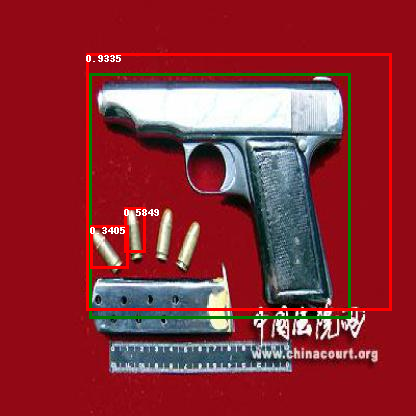

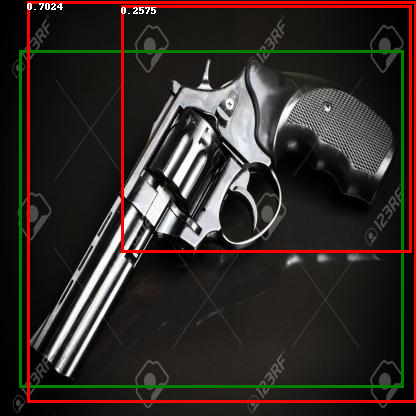

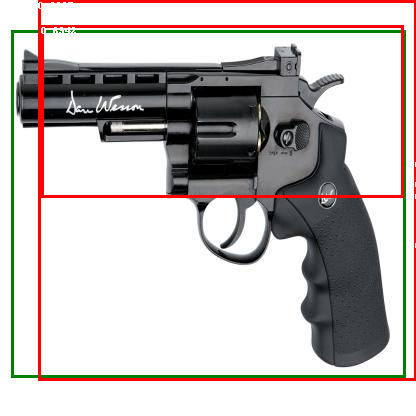

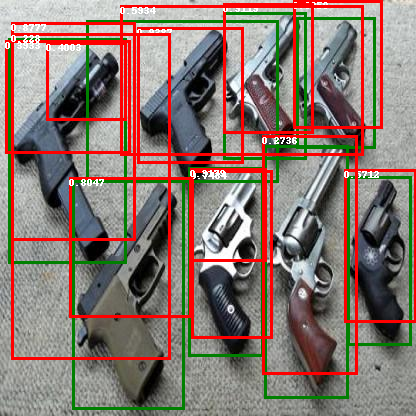

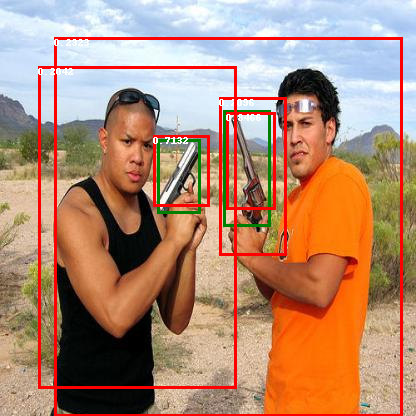

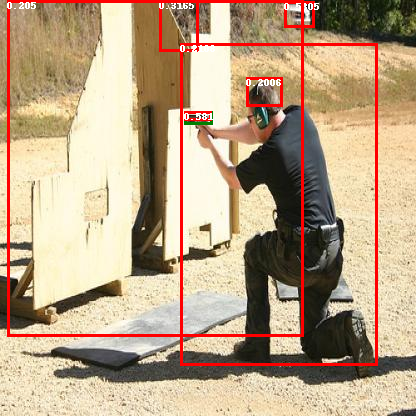

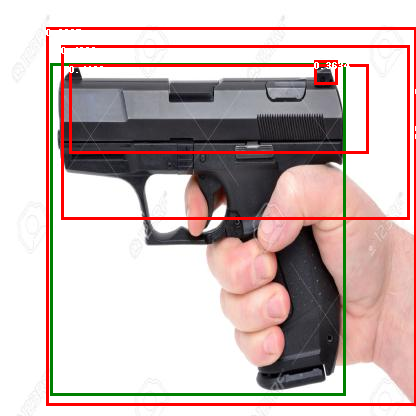

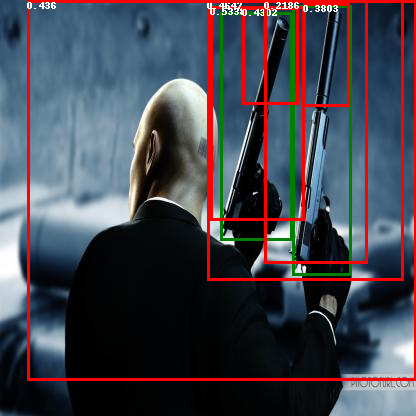

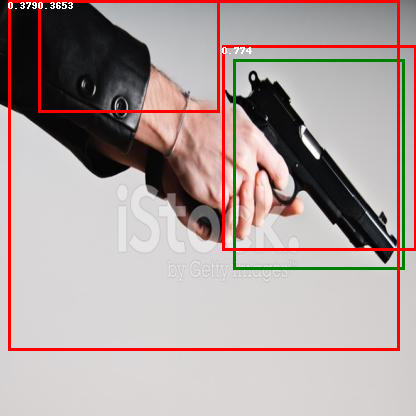

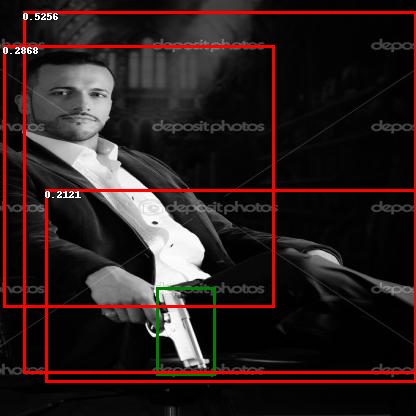

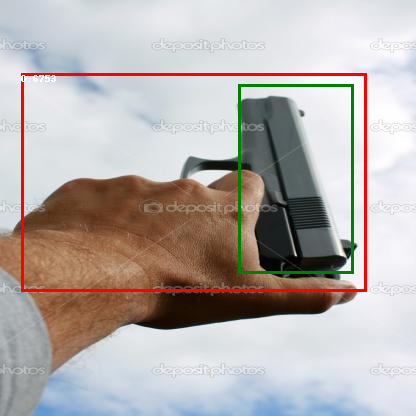

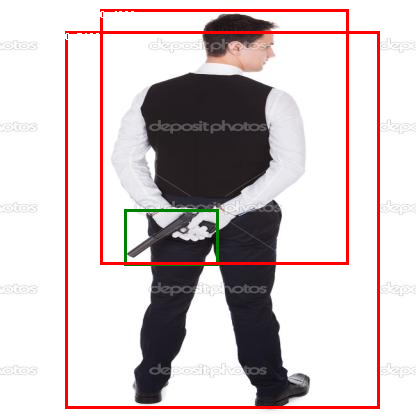

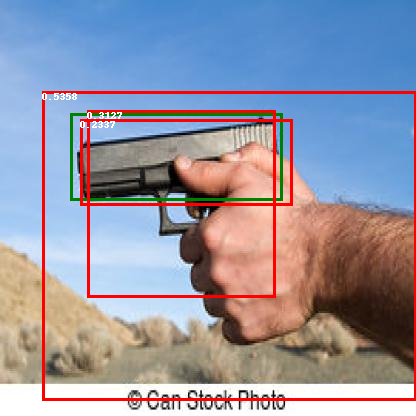

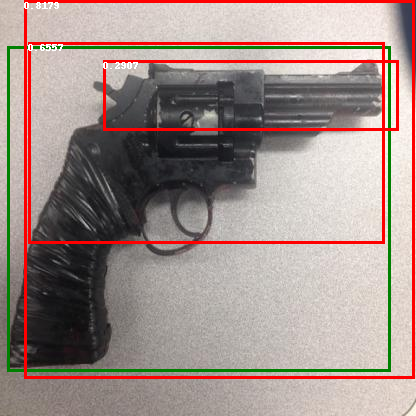

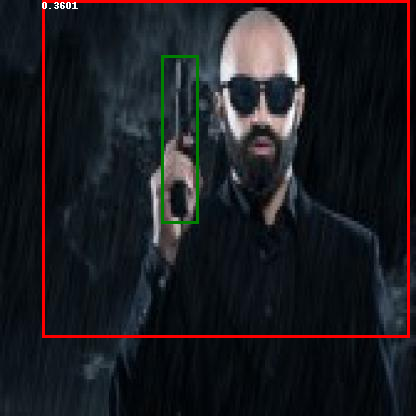

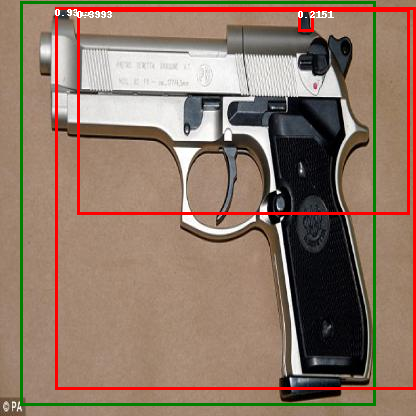

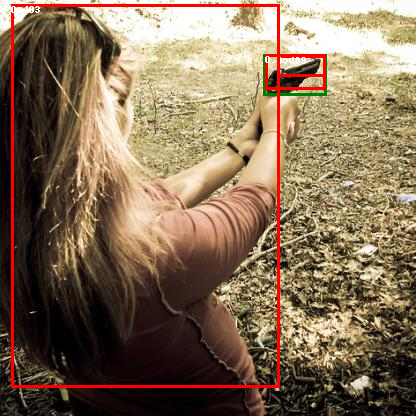

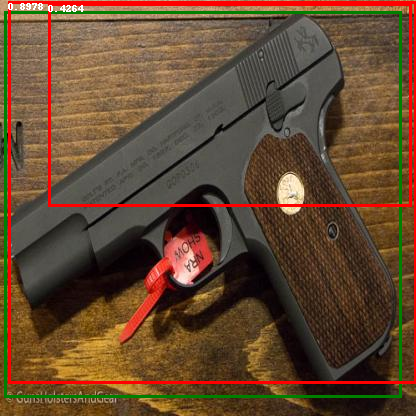

In [11]:
# Use this code to made a predition.
from PIL import ImageDraw
# Getting the image.
for idx in range(2,20):
    img, _ = test[idx]
    # Getting the object coordinates.
    label_boxes = np.array(test[idx][1]['boxes'])

    # Setting the model to eval state.
    loaded_model.eval()
    # Making the prediction.
    with torch.no_grad():
        prediction = loaded_model([img])

    # Getting an drawing the image.
    image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    draw = ImageDraw.Draw(image)

    # Drawing the real box around the object.
    for elem in range(len(label_boxes)):
        draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
                       (label_boxes[elem][2], label_boxes[elem][3])],
                      outline='green', width=3)
    # Drawing the predicted box around the object.
    for element in range(len(prediction[0]['boxes'])):
        boxes = prediction[0]['boxes'][element].cpu().numpy()                                     
        score = np.round(prediction[0]['scores'][element].cpu().numpy(), decimals=4)

        if score > 0.2:
            draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])],
                         outline='red', width=3)
            draw.text((boxes[0], boxes[1]), text=str(score))
    display(image)